
# diffusion model (Explicit)

    ↪ 원본 데이터에 noise를 주입하는 diffusion process와, noise를 제거하여 원본을 복원하는 reverse process로 구성된 생성모델

    1) diffusion process : Px(x) --> Pz(Z)
        ▢ 노이즈를 주입하여 패턴을 무너뜨림(noising)
        ▢ Iterative Markov chain : q(z|x) ==> Σq(Xt|Xt-1) : x1 ~ xt 모두 latent variable
            ↪ diffusion process는 학습하지 않음
    
    2) reverse process : Pz(z) --> P'x(x)
        ▢ 패턴을 다시 복원하는 조건부 pdf를 학습(denoising)
        ▢ Iterative Markov chain : pθ(x|z)
            ↪ 이전의 상태(t-1)에만 의존해서 다음 상태(t) 확률을 예측하여 학습

        ✔ x_tilde = αx + (1-α)ε

            α : 추가되는 노이즈의 양을 결정하는 스칼라. x와 noise의 비율. alpha = 1-beta이며, 현재 시간 단계까지의 노이즈는 누적곱인 (cumprod(alpha))를 alpha_bars로 사용함.
            ε : 평균이 0이고 분산이 1인 정규분포에서 샘플링된 noise


# diffusion Terms

    - beta schedule : 각 diffusion 단계에서 추가되는 노이즈는 '베타'라는 매개변수에 의해 제어됨. beta schedule은 모든 단계들에서 사용되는 일련의 beta값들을 의미함

        ㅁ beta schedule은 각 diffusion 단계에서 발생하는 노이즈의 양과 유형을 정의 함.

        ㅁ sigmoid : 시작과 끝의 변화량은 작고 중간 변화량이 큰 함수 모양의 노이즈를 추가

        ㅁ quad, linear(일정한 증가), const(모든 단계에서 고정된, 동일한 베타 값), jsd(모델의 예측과 실제 데이터 간의 차이가 각 단계에서 최소화 되도록 베타 값을 최적화)



#### Reference
GeoDiff: a Geometric Diffusion Model for Molecular Conformation Generation

https://github.com/MinkaiXu/GeoDiff

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install deepchem
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.2/693.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 MB 41.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 59.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.3
    Uninstalling scipy-1.11.3:
      Successfully uninstalled scipy-1.11.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
import sys
import os
import pickle
import copy
import json
from collections import defaultdict
import argparse
import networkx as nx
from tqdm import tqdm
from copy import deepcopy

import numpy as np
import random

import torch
from torch import nn
import torch.nn.functional as F

import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import Mol, HybridizationType, BondType
from rdkit import RDLogger

In [4]:
print(f'Python ver. : {sys.version}')
os.environ['TORCH'] = torch.__version__
print(f'Torch ver. : {torch.__version__}')

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git@1.7.2
!pip install -q torch-cluster -f https://data.pyg.org/whl/torch-${TORCH}.html

import torch_cluster
import torch_geometric
print(f'torch_geometric ver. : {torch_geometric.__version__}')
from torch_geometric.nn import radius_graph, radius
from torch_geometric.data import Data, Dataset, DataLoader, Batch
from torch_geometric.utils import dropout, to_dense_adj, dense_to_sparse, remove_self_loops, to_networkx
from torch_sparse import coalesce
from torch_scatter import scatter_add, scatter_mean

Python ver. : 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Torch ver. : 2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 28.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 38.0 MB/s eta 0:00:00
torch_geometric ver. : 1.7.2


In [5]:
train_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9/train_data_40k.pkl'
val_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9/val_data_5k.pkl'
test_dataset_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/dataset/QM9/test_data_1k.pkl'

params = {
    'hidden_dim': 128,
    'num_convs': 6,
    'num_convs_local': 4,
    'cutoff': 10.0,

    'beta_start': 1.e-7,
    'beta_end':  2.e-3,
    'num_diffusion_timesteps':5000,
    'edge_order': 3,
    'edge_encoder': 'mlp',
    'smooth_conv': False,

    'n_steps': 5000,
    'step_lr': 1e-6,
    'w_global': 1.0,
    'global_start_sigma': 0.5,
    'clip': 2000.0,
    'clip_local': None,
    'max_grad_norm': 10000.0,
    'scheduler_factor': 0.6,
    'scheduler_patience': 10,

    'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
}

parser = argparse.ArgumentParser()

for key, value in params.items():
    parser.add_argument('--' + key, default=value)

args = parser.parse_args('')
print(args)

Namespace(hidden_dim=128, num_convs=6, num_convs_local=4, cutoff=10.0, beta_start=1e-07, beta_end=0.002, num_diffusion_timesteps=5000, edge_order=3, edge_encoder='mlp', smooth_conv=False, n_steps=5000, step_lr=1e-06, w_global=1.0, global_start_sigma=0.5, clip=2000.0, clip_local=None, max_grad_norm=10000.0, scheduler_factor=0.6, scheduler_patience=10, device=device(type='cuda', index=0))


In [6]:
class ConformationDataset(Dataset):

    def __init__(self, path, transform=None):
        super().__init__()
        with open(path, 'rb') as f:
            self.data = pickle.load(f)
            self.data = self.data
        self.transform = transform
        self.atom_types = self._atom_types()
        self.edge_types = self._edge_types()

    def __getitem__(self, idx):

        data = self.data[idx].clone()
        if self.transform is not None:
            data = self.transform(data)
        return data

    def __len__(self):
        return len(self.data)


    def _atom_types(self):
        atom_types = set()
        for graph in self.data:
            atom_types.update(graph.atom_type.tolist())
        return sorted(atom_types)

    def _edge_types(self):
        edge_types = set()
        for graph in self.data:
            edge_types.update(graph.edge_type.tolist())
        return sorted(edge_types)

class PackedConformationDataset(ConformationDataset):
    def __init__(self, path, transform=None):
        super().__init__(path, transform)
        #k:v = idx: data_obj
        self._pack_data_by_mol()

    def _pack_data_by_mol(self):
        self._packed_data = defaultdict(list)
        if hasattr(self.data, 'idx'):
            for i in range(len(self.data)):
                self._packed_data[self.data[i].idx.item()].append(self.data[i])
        else:
            for i in range(len(self.data)):
                self._packed_data[self.data[i].smiles].append(self.data[i])
        print('[Packed] %d Molecules, %d Conformations.' % (len(self._packed_data), len(self.data)))

        new_data = []
        cnt = 0
        for k, v in self._packed_data.items():
            data = copy.deepcopy(v[0])
            all_pos = []
            for i in range(len(v)):
                all_pos.append(v[i].pos)
            data.pos_ref = torch.cat(all_pos, 0) # (num_conf*num_node, 3)
            data.num_pos_ref = torch.tensor([len(all_pos)], dtype=torch.long)

            if hasattr(data, 'totalenergy'):
                del data.totalenergy
            if hasattr(data, 'boltzmannweight'):
                del data.boltzmannweight
            new_data.append(data)
        self.new_data = new_data

    def __getitem__(self, idx):
        data = self.new_data[idx].clone()
        if self.transform is not None:
            data = self.transform(data)
        return data

    def __len__(self):
        return len(self.new_data)

class CountNodesPerGraph(object):
    def __init__(self) -> None:
        super().__init__()

    def __call__(self, data):
        data.num_nodes_per_graph = torch.LongTensor([data.num_nodes])
        return data

def inf_iterator(iterable):
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

def repeat_data(data, num_repeat):
    datas = [data.clone() for i in range(num_repeat)]
    return Batch.from_data_list(datas)


In [7]:
BOND_TYPES = {t: i for i, t in enumerate(BondType.names.values())}
BOND_NAMES = {i: t for i, t in enumerate(BondType.names.keys())}

print(BOND_TYPES)
print(BOND_NAMES)

transforms = CountNodesPerGraph()
train_set = ConformationDataset(train_dataset_path, transform=transforms)
val_set = ConformationDataset(val_dataset_path, transform=transforms)
test_set = PackedConformationDataset(test_dataset_path, transform=transforms)

print(train_set, val_set, test_set)

{rdkit.Chem.rdchem.BondType.UNSPECIFIED: 0, rdkit.Chem.rdchem.BondType.SINGLE: 1, rdkit.Chem.rdchem.BondType.DOUBLE: 2, rdkit.Chem.rdchem.BondType.TRIPLE: 3, rdkit.Chem.rdchem.BondType.QUADRUPLE: 4, rdkit.Chem.rdchem.BondType.QUINTUPLE: 5, rdkit.Chem.rdchem.BondType.HEXTUPLE: 6, rdkit.Chem.rdchem.BondType.ONEANDAHALF: 7, rdkit.Chem.rdchem.BondType.TWOANDAHALF: 8, rdkit.Chem.rdchem.BondType.THREEANDAHALF: 9, rdkit.Chem.rdchem.BondType.FOURANDAHALF: 10, rdkit.Chem.rdchem.BondType.FIVEANDAHALF: 11, rdkit.Chem.rdchem.BondType.AROMATIC: 12, rdkit.Chem.rdchem.BondType.IONIC: 13, rdkit.Chem.rdchem.BondType.HYDROGEN: 14, rdkit.Chem.rdchem.BondType.THREECENTER: 15, rdkit.Chem.rdchem.BondType.DATIVEONE: 16, rdkit.Chem.rdchem.BondType.DATIVE: 17, rdkit.Chem.rdchem.BondType.DATIVEL: 18, rdkit.Chem.rdchem.BondType.DATIVER: 19, rdkit.Chem.rdchem.BondType.OTHER: 20, rdkit.Chem.rdchem.BondType.ZERO: 21}
{0: 'UNSPECIFIED', 1: 'SINGLE', 2: 'DOUBLE', 3: 'TRIPLE', 4: 'QUADRUPLE', 5: 'QUINTUPLE', 6: 'HEXTU

In [8]:
# 원자 간의 직접적인 상호작용 뿐만 아니라 간접적인 상호작용까지 반영한 분자 그래프 생성
def extend_graph_order_radius(num_nodes, pos, edge_index, edge_type, batch, order=3, cutoff=10.0,
                              extend_order=True, extend_radius=True):
    # train만 적용
    if extend_order:
        edge_index, edge_type = _extend_graph_order(
            num_nodes=num_nodes,
            edge_index=edge_index,
            edge_type=edge_type, order=order
        )

    if extend_radius:
        edge_index, edge_type = _extend_to_radius_graph(
            pos=pos,
            edge_index=edge_index,
            edge_type=edge_type,
            cutoff=cutoff,
            batch=batch,
        )

    return edge_index, edge_type

def _extend_graph_order(num_nodes, edge_index, edge_type, order=3):
    def binarize(x):
        return torch.where(x > 0, torch.ones_like(x), torch.zeros_like(x))

    def get_higher_order_adj_matrix(adj, order):
        adj_mats = [torch.eye(adj.size(0), dtype=torch.long, device=adj.device), \
                    binarize(adj + torch.eye(adj.size(0), dtype=torch.long, device=adj.device))]

        for i in range(2, order+1):
            adj_mats.append(binarize(adj_mats[i-1] @ adj_mats[1]))
        order_mat = torch.zeros_like(adj)

        for i in range(1, order+1):
            order_mat += (adj_mats[i] - adj_mats[i-1]) * i

        return order_mat

    num_types = len(BOND_TYPES)

    N = num_nodes
    # edge_index를 dense representation으로
    adj = to_dense_adj(edge_index).squeeze(0) #(N, N)
    # 연결된 결합 차수 반영
    adj_order = get_higher_order_adj_matrix(adj, order)  # (N, N)
    # edge_index를 결합 종류가 반영된 dense representation으로
    type_mat = to_dense_adj(edge_index, edge_attr=edge_type).squeeze(0)   # (N, N)
    type_highorder = torch.where(adj_order > 1, num_types + adj_order - 1, torch.zeros_like(adj_order))
    assert (type_mat * type_highorder == 0).all()
    type_new = type_mat + type_highorder

    new_edge_index, new_edge_type = dense_to_sparse(type_new)
    _, edge_order = dense_to_sparse(adj_order)

    # data.bond_edge_index = data.edge_index  # Save original edges
    # 잠재적 중복이 제거되고 가장자리 유형이 병합될 수 있는 정규 형식의 그래프입니다.  coalesce 기능을 사용하여 edge 인덱스 및 유형에 중복되거나 불필요한 항목이 없는지 확인합니다.
    new_edge_index, new_edge_type = coalesce(new_edge_index, new_edge_type.long(), N, N) # modify data

    return new_edge_index, new_edge_type


def _extend_to_radius_graph(pos, edge_index, edge_type, cutoff, batch, unspecified_type_number=0):
    assert edge_type.dim() == 1
    N = pos.size(0)

    # sparse representation
    bgraph_adj = torch.sparse.LongTensor(
        edge_index,
        edge_type,
        torch.Size([N, N])
    ).to(pos.device)

    # 반경(cutoff) 이내의 모든 점(pos)를 edge_index로 표현
    rgraph_edge_index = radius_graph(pos, r=cutoff, batch=batch).to(pos.device)    # (2, E_r)
    # rgraph_edge_index의 sparse representation
    rgraph_adj = torch.sparse.LongTensor(
        rgraph_edge_index,
        torch.ones(rgraph_edge_index.size(1)).long().to(pos.device) * unspecified_type_number,
        torch.Size([N, N])
    )
    composed_adj = (bgraph_adj + rgraph_adj).coalesce()  # Sparse (N, N, T)
    new_edge_index = composed_adj.indices()
    new_edge_type = composed_adj.values().long()

    return new_edge_index, new_edge_type

# 연결된 두 node의 유클리드 거리 계
def get_distance(pos, edge_index):
    return (pos[edge_index[0]] - pos[edge_index[1]]).norm(dim=-1)

def get_sigmoid_beta_schedule(beta_start, beta_end, num_diffusion_timesteps) :
    def sigmoid(x) :
        return 1 / (np.exp(-x)+1)

    betas = np.linspace(-6, 6, num_diffusion_timesteps)
    betas = sigmoid(betas) * ( beta_end - beta_start) + beta_start
    betas = torch.from_numpy(betas).float()

    assert betas.shape == (num_diffusion_timesteps, )
    return betas

# edge로 연결된 node 쌍의 attr을 곱해서, edge_attr과 이어붙임
def assemble_atom_pair_feature(node_attr, edge_index, edge_attr):
    h_row, h_col = node_attr[edge_index[0]], node_attr[edge_index[1]]
    h_pair = torch.cat([h_row*h_col, edge_attr], dim=-1)    # (E, 2H)
    return h_pair

def is_train_edge(edge_index) :
    return torch.ones(edge_index.size(1), device=edge_index.device).bool()

def eq_score(score_dist, pos, edge_index, edge_length):
    # 노드 갯수
    N = pos.size(0)
    # 정규화된 directional derivatives. 두 node의 위치 차이를 edge_length로 나눔(방향 미분)
    dd_dr = (1. / edge_length) * (pos[edge_index[0]] - pos[edge_index[1]])   # (E, 3)
    # node index에 따라 score 분산 합 계산
    score_pos = scatter_add(dd_dr * score_dist, edge_index[0], dim=0, dim_size=N) \
        + scatter_add(- dd_dr * score_dist, edge_index[1], dim=0, dim_size=N) # (N, 3)
    return score_pos

def clip_norm(vec, limit, p=2):
    # 벡터의 유클리드 거리(p=2) 계산
    norm = torch.norm(vec, dim=-1, p=2, keepdim=True)
    # norm이 limit보다 클 경우 항상 limit값을 리턴, limit보다 작거나 같을 경우 vec값을 리턴
    denom = torch.where(norm > limit, limit / norm, torch.ones_like(norm))
    return vec * denom

def center_pos(pos, batch):
    pos_center = pos - scatter_mean(pos, batch, dim=0)[batch]
    return pos_center

In [9]:
class ShiftedSoftplus(torch.nn.Module):
    def __init__(self):
        super(ShiftedSoftplus, self).__init__()
        self.shift = torch.log(torch.tensor(2.0)).item()

    def forward(self, x):
        return F.softplus(x) - self.shift


class CFConv(torch_geometric.nn.MessagePassing):
    def __init__(self, in_channels, out_channels, num_filters, mlp, cutoff, smooth):
        super(CFConv, self).__init__(aggr='add')
        self.lin1 = nn.Linear(in_channels, num_filters, bias=False)
        self.lin2 = nn.Linear(num_filters, out_channels)
        self.mlp = mlp
        self.cutoff = cutoff
        self.smooth = smooth
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.lin1.weight)
        torch.nn.init.xavier_uniform_(self.lin2.weight)
        self.lin2.bias.data.fill_(0)

    def forward(self, x, edge_index, edge_attr, edge_length):
        if edge_length != None :
            C = (edge_length <= self.cutoff).float()
            W = self.mlp(edge_attr) * C.view(-1, 1)
        else :
            W = self.mlp(edge_attr)

        x = self.lin1(x)
        x = self.propagate(edge_index, x=x, W=W)
        x = self.lin2(x)
        return x

    def message(self, x_j, W):
        return x_j * W


class InteractionBlock(nn.Module):
    def __init__(self, hidden_channels, num_gaussians, num_filters, cutoff, smooth):
        super(InteractionBlock, self).__init__()
        mlp = nn.Sequential(
            nn.Linear(num_gaussians, num_filters),
            ShiftedSoftplus(),
            nn.Linear(num_filters, num_filters),
        )
        self.conv = CFConv(hidden_channels, hidden_channels, num_filters, mlp, cutoff, smooth)
        self.act = ShiftedSoftplus()
        self.lin = nn.Linear(hidden_channels, hidden_channels)

    def forward(self, x, edge_index, edge_attr, edge_length):
        x = self.conv(x, edge_index, edge_attr, edge_length)
        x = self.act(x)
        x = self.lin(x)
        return x


class SchNetEncoder(nn.Module):
    def __init__(self, hidden_channels=128, num_filters=128,
                num_interactions=6, edge_channels=100, cutoff=10.0, smooth=False):
        super().__init__()

        self.hidden_channels = hidden_channels
        self.num_filters = num_filters
        self.num_interactions = num_interactions
        self.cutoff = cutoff

        self.embedding = nn.Embedding(100, hidden_channels, max_norm=10.0)

        self.interactions = nn.ModuleList()
        for _ in range(num_interactions):
            block = InteractionBlock(hidden_channels, edge_channels,
                                     num_filters, cutoff, smooth)
            self.interactions.append(block)

    def forward(self, z, edge_index, edge_attr, edge_length=None, embed_node=True):
        if embed_node:
            assert z.dim() == 1 and z.dtype == torch.long
            h = self.embedding(z)
        else:
            h = z
        for interaction in self.interactions:
            h = h + interaction(h, edge_index, edge_attr, edge_length)

        return h

class MLPEdgeEncoder(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=100, n_en_layers=3, dropout=0):
        super().__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_en_layers = n_en_layers
        self.bond_emb = nn.Embedding(100, embedding_dim=self.hidden_dim)
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
            [nn.Linear(
                self.input_dim if i==0 else self.hidden_dim,
                self.hidden_dim) for i in range(self.n_en_layers)
            ])

    @property
    def out_channels(self):
        return self.hidden_dim

    def encode(self, x) :
        for i, layer in enumerate(self.layers, 1) :
            x = layer(x)
            if i != self.n_en_layers :
                x = x.relu()
            x = self.dropout(x)
        return x

    def forward(self, edge_length, edge_type):
        d_emb = self.encode(edge_length) # (num_edge, hidden_dim)
        edge_attr = self.bond_emb(edge_type) # (num_edge, hidden_dim)
        return d_emb * edge_attr # (num_edge, hidden_dim)


class DistMLP(nn.Module):
    def __init__(self, hidden_dims, dropout=0):
        super().__init__()
        self.hidden_dims = hidden_dims
        self.dropout = nn.Dropout(dropout)
        self.layers = nn.ModuleList(
            [nn.Linear(
                self.hidden_dims[i-1],
                self.hidden_dims[i]) for i in range(1, len(self.hidden_dims))
            ])

    def forward(self, x) :
        for i, layer in enumerate(self.layers, 1) :
            x = layer(x)
            if i != len(self.layers) :
                x = x.relu()
            x = self.dropout(x)
        return x

In [10]:
class DiffusionModel(nn.Module) :
    def __init__(self, args) :
        super().__init__()
        self.args = args

        self.edge_encoder_global = MLPEdgeEncoder(hidden_dim=args.hidden_dim).to(self.args.device)
        self.edge_encoder_local = MLPEdgeEncoder(hidden_dim=args.hidden_dim).to(self.args.device)

        self.encoder_global = SchNetEncoder(
            hidden_channels=args.hidden_dim,
            num_filters=args.hidden_dim,
            num_interactions=args.num_convs,
            edge_channels=self.edge_encoder_global.out_channels,
            cutoff=args.cutoff,
        )

        self.encoder_local = SchNetEncoder(
            hidden_channels=args.hidden_dim,
            num_filters=args.hidden_dim,
            num_interactions=args.num_convs,
            edge_channels=self.edge_encoder_local.out_channels,
        )

        self.grad_global_dist_mlp = DistMLP(
            [2*args.hidden_dim, args.hidden_dim, args.hidden_dim // 2, 1],
        )

        self.grad_local_dist_mlp = DistMLP(
            [2*args.hidden_dim, args.hidden_dim, args.hidden_dim // 2, 1],
        )

        self.model_global = nn.ModuleList([self.edge_encoder_global, self.encoder_global, self.grad_global_dist_mlp])
        self.model_local = nn.ModuleList([self.edge_encoder_local, self.encoder_local, self.grad_local_dist_mlp])

        # sequence :  0(original data) ~ 4999(pure noise)
        # betas : 각 sequnece에 추가되는 노이즈의 양을 결정하는 noise schedule
        betas = get_sigmoid_beta_schedule(
            beta_start=args.beta_start,
            beta_end=args.beta_end,
            num_diffusion_timesteps=args.num_diffusion_timesteps,
        )
        # alphas : 누적곱. 각 단계에서 original data의 보존된 정도를 나타냄
        alphas = (1. - betas).cumprod(dim=0)

        self.betas = nn.Parameter(betas, requires_grad=False)
        self.alphas = nn.Parameter(alphas, requires_grad=False)
        self.num_timesteps = self.betas.size(0)

    def forward(self, atom_type, pos, bond_index, bond_type, batch, time_step,
                edge_index=None, edge_type=None, edge_length=None, return_edges=False,
                extend_order=True, extend_radius=True) :

        N = atom_type.size(0)
        if edge_index is None or edge_type is None or edge_length is None:
            edge_index, edge_type = extend_graph_order_radius(
                num_nodes=N,
                pos=pos,
                edge_index=bond_index,
                edge_type=bond_type,
                batch=batch,
                order=self.args.edge_order,
                cutoff=self.args.cutoff,
                extend_order=extend_order,
                extend_radius=extend_radius,
            )
            # edge_index로 연결된 pos의 거리
            edge_length = get_distance(pos, edge_index).unsqueeze(-1)   # (E, 1)

        local_edge_mask = edge_type > 0  # (E, )
        sigma_edge = torch.ones(size=(edge_index.size(1), 1), device=pos.device)  # (E, 1)

        edge_attr_global = self.edge_encoder_global(
            edge_length=edge_length,
            edge_type=edge_type
        )

        # Global
        node_attr_global = self.encoder_global(
            z=atom_type,
            edge_index=edge_index,
            edge_length=edge_length,
            edge_attr=edge_attr_global,
        )

        ## Assemble pairwise features
        h_pair_global = assemble_atom_pair_feature(
            node_attr=node_attr_global,
            edge_index=edge_index,
            edge_attr=edge_attr_global,
        )    # (E_global, 2H)

        ## Invariant features of edges (radius graph, global)
        edge_inv_global = self.grad_global_dist_mlp(h_pair_global) * (1.0 / sigma_edge)    # (E_global, 1)

        # Encoding local
        edge_attr_local = self.edge_encoder_local(
            edge_length=edge_length,
            edge_type=edge_type
        )   # Embed edges

        # Local
        node_attr_local = self.encoder_local(
            z=atom_type,
            edge_index=edge_index[:, local_edge_mask],
            edge_attr=edge_attr_local[local_edge_mask],
        )

        ## Assemble pairwise features
        h_pair_local = assemble_atom_pair_feature(
            node_attr=node_attr_local,
            edge_index=edge_index[:, local_edge_mask],
            edge_attr=edge_attr_local[local_edge_mask],
        )    # (E_local, 2H)

        # Invariant features of edges (bond graph, local)
        if isinstance(sigma_edge, torch.Tensor):
            edge_inv_local = self.grad_local_dist_mlp(h_pair_local) * (1.0 / sigma_edge[local_edge_mask]) # (E_local, 1)
        else:
            edge_inv_local = self.grad_local_dist_mlp(h_pair_local) * (1.0 / sigma_edge) # (E_local, 1)

        # train : True, test : False
        if return_edges:
            return edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask
        else:
            return edge_inv_global, edge_inv_local


    def get_loss(self, atom_type, pos, bond_index, bond_type, batch,
                 num_nodes_per_graph, num_graphs, anneal_power=2.0,
                 return_unreduced_loss=False, return_unreduced_edge_loss=False,
                 extend_order=True, extend_radius=True):

        N = atom_type.size(0)
        node2graph = batch  # (num_node, )

        # 미러링된 랜덤한 timestep 생성
        time_step = torch.randint(
            0, self.num_timesteps, size=(num_graphs//2+1, ), device=pos.device)
        time_step = torch.cat(
            [time_step, self.num_timesteps-time_step-1], dim=0)[:num_graphs]

        # 랜덤하게 선택된 timestep index에 해당하는 alphas 선택
        a = self.alphas.index_select(0, time_step)
        # 랜덤하게 선택된 timestep index를 pos에 매칭
        a_pos = a.index_select(0, node2graph).unsqueeze(-1)
        # pos shape의 noise 생성
        pos_noise = torch.zeros(size=pos.size(), device=pos.device)
        pos_noise.normal_()

        pos_tilde = pos + pos_noise * (1.0 - a_pos).sqrt() / a_pos.sqrt()

        edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask = self(
            atom_type = atom_type,
            pos = pos_tilde,
            bond_index = bond_index,
            bond_type = bond_type,
            batch = batch,
            time_step = time_step,
            return_edges = True,
            extend_order = extend_order,
            extend_radius = extend_radius,
        )   # (E_global, 1), (E_local, 1)

        edge2graph = node2graph.index_select(0, edge_index[0]) # (num_edges, )
        a_edge = a.index_select(0, edge2graph).unsqueeze(-1) # (num_edges, 1)

        dist = get_distance(pos, edge_index).unsqueeze(-1) # (num_edges, 1)
        dist_tilde = edge_length # (num_edges, 1)
        dist_target = (dist - dist_tilde) / (1.0 - a_edge).sqrt() * a_edge.sqrt() #(num_edges, 1)

        ## global loss
        # local_edge_mask가 아닌 것 중 cutoff보다 작은 dist_tilde 값을 취함
        global_mask = torch.logical_and(
            torch.logical_or( dist_tilde <= self.args.cutoff, local_edge_mask.unsqueeze(-1) ),
            ~local_edge_mask.unsqueeze(-1)
        ) # (num_edges, 1)
        # global_mask가 True라면 dist_target의 값, False라면 0
        dist_target_global = torch.where(global_mask, dist_target, torch.zeros_like(dist_target)) # (num_edges, 1)
        # global_mask가 True라면 edge_inv_global, False라면 0
        edge_inv_global = torch.where(global_mask, edge_inv_global, torch.zeros_like(edge_inv_global)) # (num_edges, 1)

        # noise로 pertuated된 차이에 대한 위치 수정 값
        x_score_global = eq_score(dist_target_global, pos_tilde, edge_index, edge_length) # (num_nodes, 3)
        # noise로 pertuated된 차이에 대해 모델이 예측한 위치 수정 값
        pred_score_global = eq_score(edge_inv_global, pos_tilde, edge_index, edge_length) # (num_nodes, 3)

        loss_global = (x_score_global - pred_score_global)**2 # (num_nodes, 3)
        loss_global = 2 * torch.sum(loss_global, dim=-1, keepdim=True) # (num_nodes, 1)

        ## local loss
        # noise로 pertuated된 차이에 대한 위치 수정 값
        x_score_local = eq_score(dist_target[local_edge_mask], pos_tilde, edge_index[:, local_edge_mask], edge_length[local_edge_mask])  # (num_nodes, 3)
        # noise로 pertuated된 차이에 대해 모델이 예측한 위치 수정 값
        pred_score_local = eq_score(edge_inv_local, pos_tilde, edge_index[:, local_edge_mask], edge_length[local_edge_mask]) # (num_nodes, 3)

        loss_local = (x_score_local - pred_score_local)**2 # (num_nodes, 3)
        loss_local = 5 * torch.sum(loss_local, dim=-1, keepdim=True)

        loss = loss_global + loss_local
        return loss_global, loss_local

    def langevin_dynamics_sample(self, atom_type, pos_init, bond_index, bond_type,
                                 batch, num_graphs, extend_order, extend_radius=True,
                                 n_steps=100, step_lr=1e-6, clip=1000, clip_local=None,
                                 clip_pos=None, min_sigma=0, global_start_sigma=float('inf'),
                                 w_global=0.2, w_reg=1.0, **kwargs) :

        def compute_alpha(beta, t) :
            beta = torch.cat( [ torch.zeros(1).to(beta.device), beta ], dim=0 )
            a = (1 - beta).cumprod(dim=0).index_select(0, t+1)

            return a

        # sigmas : noise가 추가된 정도. 값이 클수록 noise가 많다는걸 의미
        sigmas = (1.0 - self.alphas).sqrt() / self.alphas.sqrt() # (num_timesteps, )
        self.sigmas = sigmas
        pos_traj = []

        with torch.no_grad() :
            seq = range(self.num_timesteps - n_steps, self.num_timesteps)
            seq_next = [-1] + list(seq[:-1])

            pos = pos_init * sigmas[-1]
            # reverse diffusion process : noise로부터 sequential하게 molecule을 복원
            # seq(i): 4999, 4998, ... 0
            # seq_next(j): 4998, 4997, ... -1
            for i, j in tqdm(zip(reversed(seq), reversed(seq_next)), desc='sample') :
                t = torch.full(size=(num_graphs,), fill_value=i, dtype=torch.long, device=pos.device) # (batch_size,)

                edge_inv_global, edge_inv_local, edge_index, edge_type, edge_length, local_edge_mask = self(
                    atom_type=atom_type,
                    pos=pos,
                    bond_index=bond_index,
                    bond_type=bond_type,
                    batch=batch,
                    time_step=t,
                    return_edges=True,
                    extend_order=extend_order,
                    extend_radius=extend_radius,
                ) # (E_global, 1), (E_local, 1)

                # global
                # noise의 정도(sigmas[i])가 임계점(global_start_sigma)보다 작을 때부터 시작
                if sigmas[i] < global_start_sigma :
                    edge_inv_global = edge_inv_global * (1-local_edge_mask.view(-1, 1).float())
                    pred_score_global = eq_score(edge_inv_global, pos, edge_index, edge_length) # (num_nodes, 3)
                    pred_score_global = clip_norm(pred_score_global, limit=clip)
                else :
                    pred_score_global = 0

                # local
                pred_score_local = eq_score(edge_inv_local, pos, edge_index[:, local_edge_mask], edge_length[local_edge_mask])
                eps_pos = pred_score_local + pred_score_global * w_global

                ## sampling
                noise = torch.randn_like(pos) #(num_nodes, 3)
                b = self.betas
                t = t[0]
                next_t = (torch.ones(1) * j).to(pos.device)

                # at_next > at
                at = compute_alpha(b, t.long())
                at_next = compute_alpha(b, next_t.long())
                beta_t = 1 - at / at_next
                # e : 모델로 예측된 noise를 제거하는 pos 변화량
                e = -eps_pos # (num_nodes, 3)
                # 시간 단계 t에 대해 더해졌던 noise를 제거한 pos
                pos0_from_e = (1.0 / at).sqrt() * pos - (1.0 / at - 1).sqrt() * e #(num_nodes, 3)
                # 다음 단계의 평균 예상 위치(잡음이 제거된 후의 위치 + 현재 위치)
                # at, beta 등은 노이즈의 영향을 받을 것으로 예상되는 정도를 조정하는 역할
                mean = (
                    (at_next.sqrt() * beta_t) * pos0_from_e +
                    ((1-beta_t).sqrt() * (1-at_next))*pos
                ) / (1.0 - at) # (num_nodes, 3)
                mask = 1 - (t==0).float()
                logvar = beta_t.log()
                pos_next = mean + mask * torch.exp(0.5 * logvar) * noise
                pos = pos_next

                if torch.isnan(pos).any() :
                    print('NaN detected. Please restart.')
                    raise FloatingPointError()
                pos = center_pos(pos, batch)
                pos_traj.append(pos.clone().cpu())

        return pos, pos_traj

In [11]:
batch_size = 64
train_dataloader = DataLoader(train_set, batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size, shuffle=False)

model = DiffusionModel(args).to(args.device)
optimizer_global = torch.optim.Adam(model.model_global.parameters(), lr=1.e-3, betas=(0.95, 0.999))
optimizer_local = torch.optim.Adam(model.model_local.parameters(), lr=1.e-3, betas=(0.95, 0.999))

scheduler_global = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer_global,
            factor=args.scheduler_factor,
            patience=args.scheduler_patience,
        )
scheduler_local = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer_local,
            factor=args.scheduler_factor,
            patience=args.scheduler_patience,
        )

In [ ]:
### train
for i in tqdm(range(25)) :
    epoch_train_loss = 0
    global_val_loss = 0
    local_val_loss = 0

    model.train()
    for idx, data in enumerate(train_dataloader) :
        data = data.to(args.device)
        optimizer_global.zero_grad()
        optimizer_local.zero_grad()

        loss_global, loss_local = model.get_loss(atom_type=data.atom_type,
                    pos=data.pos,
                    bond_index=data.edge_index,
                    bond_type=data.edge_type,
                    batch=data.batch,
                    num_nodes_per_graph=data.num_nodes_per_graph,
                    num_graphs=data.num_graphs,
                    return_unreduced_loss=True)

        loss_global = loss_global.mean()
        loss_local = loss_local.mean()

        loss_global.backward()
        loss_local.backward()

        orig_grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)

        optimizer_global.step()
        optimizer_local.step()

        epoch_train_loss += (loss_global.item() + loss_local.item())
    epoch_train_loss /= len(train_dataloader)

### validation
    model.eval()
    with torch.no_grad() :
        for idx, data in enumerate(val_dataloader) :
            data = data.to(args.device)

            loss_global, loss_local = model.get_loss(atom_type=data.atom_type,
                        pos=data.pos,
                        bond_index=data.edge_index,
                        bond_type=data.edge_type,
                        batch=data.batch,
                        num_nodes_per_graph=data.num_nodes_per_graph,
                        num_graphs=data.num_graphs,
                        return_unreduced_loss=True)

            loss_global = loss_global.mean()
            loss_local = loss_local.mean()

            global_val_loss += loss_global.item()
            local_val_loss += loss_local.item()
    global_val_loss /= len(val_dataloader)
    local_val_loss /= len(val_dataloader)

    scheduler_global.step(global_val_loss)
    scheduler_local.step(local_val_loss)

    print(f'Train Loss : {epoch_train_loss:.4f}, Validation Loss : {(global_val_loss + local_val_loss):.4f}')

  4%|▍         | 1/25 [04:55<1:58:07, 295.31s/it]

Train Loss : 1055.0303, Validation Loss : 192.1425


  8%|▊         | 2/25 [09:43<1:51:42, 291.40s/it]

Train Loss : 181.6595, Validation Loss : 163.0773


 12%|█▏        | 3/25 [14:42<1:47:58, 294.47s/it]

Train Loss : 162.0639, Validation Loss : 166.6243


 16%|█▌        | 4/25 [19:41<1:43:44, 296.39s/it]

Train Loss : 153.2228, Validation Loss : 161.5607


 20%|██        | 5/25 [24:31<1:37:58, 293.95s/it]

Train Loss : 80604.9807, Validation Loss : 160.3817


 24%|██▍       | 6/25 [29:27<1:33:22, 294.87s/it]

Train Loss : 143.2832, Validation Loss : 148.2627


 28%|██▊       | 7/25 [34:23<1:28:34, 295.24s/it]

Train Loss : 134.9285, Validation Loss : 131.4595


 32%|███▏      | 8/25 [39:10<1:22:52, 292.49s/it]

Train Loss : 130.9289, Validation Loss : 121.6616


 36%|███▌      | 9/25 [44:06<1:18:16, 293.54s/it]

Train Loss : 128.2804, Validation Loss : 120.2308


 40%|████      | 10/25 [48:53<1:12:53, 291.54s/it]

Train Loss : 173.1486, Validation Loss : 136.1300


 44%|████▍     | 11/25 [53:50<1:08:25, 293.24s/it]

Train Loss : 203.4818, Validation Loss : 127.3429


 48%|████▊     | 12/25 [58:46<1:03:44, 294.21s/it]

Train Loss : 122.3789, Validation Loss : 119.6546


 52%|█████▏    | 13/25 [1:03:34<58:25, 292.10s/it]

Train Loss : 121.3284, Validation Loss : 114.2367


 56%|█████▌    | 14/25 [1:08:30<53:48, 293.53s/it]

Train Loss : 4571.1551, Validation Loss : 117.6551


 60%|██████    | 15/25 [1:13:26<49:00, 294.03s/it]

Train Loss : 119.3186, Validation Loss : 114.0692


 64%|██████▍   | 16/25 [1:18:12<43:45, 291.77s/it]

Train Loss : 116.5551, Validation Loss : 115.9465


 68%|██████▊   | 17/25 [1:23:07<39:02, 292.87s/it]

Train Loss : 116.3526, Validation Loss : 114.5782


 72%|███████▏  | 18/25 [1:27:55<33:59, 291.41s/it]

Train Loss : 118.4147, Validation Loss : 110.7799


 76%|███████▌  | 19/25 [1:32:51<29:15, 292.58s/it]

Train Loss : 114.3406, Validation Loss : 130.5265


 80%|████████  | 20/25 [1:37:48<24:29, 293.99s/it]

Train Loss : 114.7167, Validation Loss : 130.2997


 84%|████████▍ | 21/25 [1:42:36<19:28, 292.24s/it]

Train Loss : 113.2446, Validation Loss : 110.9443


 88%|████████▊ | 22/25 [1:47:33<14:40, 293.46s/it]

Train Loss : 111.4063, Validation Loss : 117.8121


 92%|█████████▏| 23/25 [1:52:28<09:48, 294.21s/it]

Train Loss : 110.8017, Validation Loss : 105.1173


 96%|█████████▌| 24/25 [1:57:16<04:52, 292.19s/it]

Train Loss : 110.5824, Validation Loss : 110.1765


100%|██████████| 25/25 [2:02:12<00:00, 293.31s/it]

Train Loss : 118.1684, Validation Loss : 127.8632


In [ ]:
ckpt_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/diffusion_tutorial_231026.pth'

torch.save({
        'config': args,
        'model': model.state_dict(),
        'optimizer_global': optimizer_global.state_dict(),
        'optimizer_local': optimizer_local.state_dict(),
        'scheduler_global': scheduler_global.state_dict(),
        'scheduler_local': scheduler_local.state_dict(),
        'iteration': i,
        'avg_val_loss': global_val_loss + local_val_loss,
    }, ckpt_path)

In [12]:
ckpt_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/diffusion_tutorial.pth'
ckpt = torch.load(ckpt_path, map_location=args.device)
print(ckpt.keys())

model = DiffusionModel(args).to(args.device)
optimizer_global = torch.optim.Adam(model.model_global.parameters(), lr=1.e-3, betas=(0.95, 0.999))
optimizer_local = torch.optim.Adam(model.model_local.parameters(), lr=1.e-3, betas=(0.95, 0.999))

model.load_state_dict(ckpt['model'])
optimizer_global.load_state_dict(ckpt['optimizer_global'])
optimizer_local.load_state_dict(ckpt['optimizer_local'])

dict_keys(['config', 'model', 'optimizer_global', 'optimizer_local', 'iteration', 'avg_val_loss'])


In [21]:
### test
start_idx = 800
end_idx = 810

test_set_selected = []
done_smiles = set()
results=[]

for i, data in enumerate(test_set) :
    if not (start_idx <= i < end_idx): continue
    test_set_selected.append(data)

print(len(test_set_selected), test_set_selected)

10 [Data(atom_type=[20], edge_index=[2, 38], edge_type=[38], idx=[1], num_nodes_per_graph=[1], num_pos_ref=[1], nx=Graph with 20 nodes and 19 edges, pos=[20, 3], pos_ref=[1200, 3], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7b6dd15085f0>, smiles="CC[C@@](C#N)(CO)OC"), Data(atom_type=[19], edge_index=[2, 36], edge_type=[36], idx=[1], num_nodes_per_graph=[1], num_pos_ref=[1], nx=Graph with 19 nodes and 18 edges, pos=[19, 3], pos_ref=[1672, 3], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7b6dd1508820>, smiles="C#C[C@H](O)C(CO)CO"), Data(atom_type=[19], edge_index=[2, 38], edge_type=[38], idx=[1], num_nodes_per_graph=[1], num_pos_ref=[1], nx=Graph with 19 nodes and 19 edges, pos=[19, 3], pos_ref=[1064, 3], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7b6dd1508890>, smiles="C#C[C@]1(CCO)C[C@H]1O"), Data(atom_type=[23], edge_index=[2, 44], edge_type=[44], idx=[1], num_nodes_per_graph=[1], num_pos_ref=[1], nx=Graph with 23 nodes and 22 edges, pos=[23, 3], pos_ref=[6072, 3], rdmol=<rdkit.Chem.rdchem.Mo

In [22]:
for idx, data in enumerate(test_set_selected) :
    num_refs = data.pos_ref.size(0) // data.num_nodes

    data_input = data.clone()
    data_input['pos_ref'] = None

    batch = repeat_data(data_input, num_refs).to(args.device)
    model.eval()

    pos_init = torch.randn(batch.num_nodes, 3).to(args.device)
    pos_gen, pos_traj = model.langevin_dynamics_sample(
                atom_type=batch.atom_type,
                pos_init=pos_init,
                bond_index=batch.edge_index,
                bond_type=batch.edge_type,
                batch=batch.batch,
                num_graphs=batch.num_graphs,
                extend_order=False,
                n_steps=args.n_steps,
                step_lr=1e-6,
                w_global=args.w_global,
                global_start_sigma=args.global_start_sigma,
                clip=args.clip,
                clip_local=args.clip_local
    )

    pos_gen = pos_gen.cpu()
    data_input['pos_gen'] = pos_gen
    results.append(data_input)

sample: 0it [00:00, ?it/s]<ipython-input-8-745fe0a9fd60>:68: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:605.)
  bgraph_adj = torch.sparse.LongTensor(
sample: 5000it [01:04, 77.76it/s]
sample: 5000it [01:02, 79.83it/s]
sample: 5000it [01:00, 82.07it/s]
sample: 5000it [01:45, 47.21it/s]
sample: 5000it [01:02, 80.50it/s]
sample: 5000it [01:03, 78.98it/s]
sample: 5000it [01:03, 78.83it/s]
sample: 5000it [01:50, 45.18it/s]
sample: 5000it [01:13, 68.24it/s]
sample: 5000it [01:05, 76.15it/s]


In [23]:
test_pos_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/test_pos.pth'

torch.save({
        'results': results,
    }, test_pos_path)

In [24]:
test_pos_path = '/content/drive/MyDrive/Colab Notebooks/Python/Portfolio/model/test_pos.pth'
results = torch.load(test_pos_path, map_location=args.device)
print(results.keys())
data = results['results'][0]
print(data)

dict_keys(['results'])
Data(atom_type=[20], edge_index=[2, 38], edge_type=[38], idx=[1], num_nodes_per_graph=[1], num_pos_ref=[1], nx=Graph with 20 nodes and 19 edges, pos=[20, 3], pos_gen=[1200, 3], rdmol=<rdkit.Chem.rdchem.Mol object at 0x7b6dbd09c0e0>, smiles="CC[C@@](C#N)(CO)OC")


CC[C@@](C#N)(CO)OC


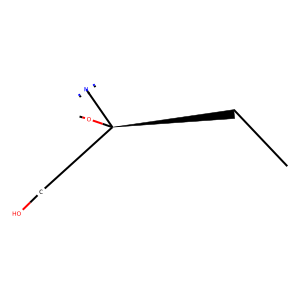

C#C[C@H](O)[C@@H](CO)CO


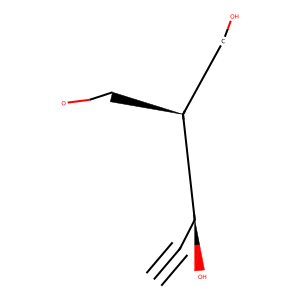

C#C[C@]1(CCO)C[C@H]1O


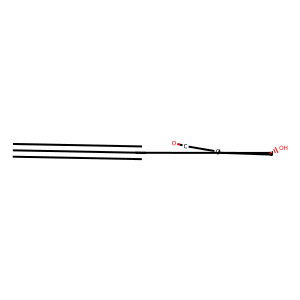

C#CCCC[C@@H](C)CO


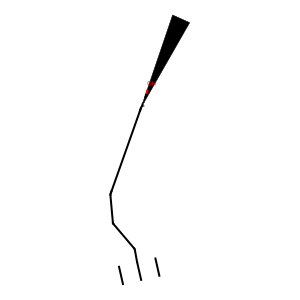

CN[C@@H](C=O)/C(C)=N/O


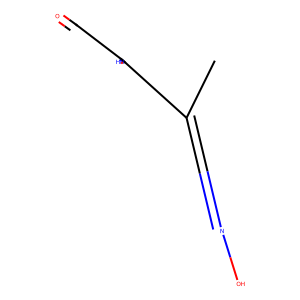

CCC[C@H]1C[C@H]1OCC


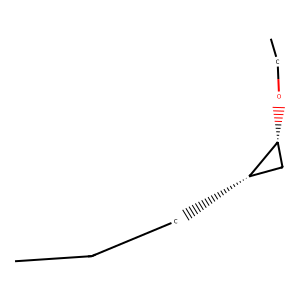

C[C@@](C)(CO)[C@@H](N)C#N


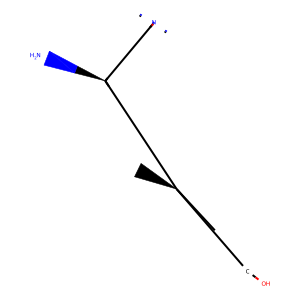

N#C[C@@](N)(CN)CCO


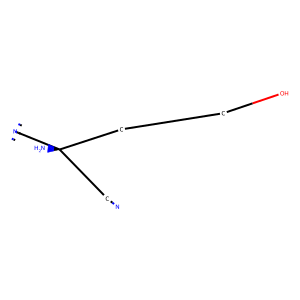

CO[C@H]1C[C@H]1CCCO


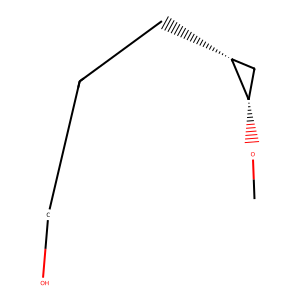

CCCCOCC=O


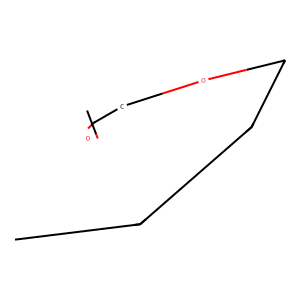

In [26]:
def set_rdmol_positions(rdkit_mol, pos):
    mol = deepcopy(rdkit_mol)
    for i in range(pos.shape[0]):
        mol.GetConformer(0).SetAtomPosition(i, pos[i].tolist())
    return mol

for i in range(len(results['results'])) :
    data = results['results'][i]

    real_gen = data['pos'].reshape(-1, data['rdmol'].GetNumAtoms(), 3)
    test_gen = data['pos_gen'].reshape(-1, data['rdmol'].GetNumAtoms(), 3)
    num_real_gen = real_gen.shape[0]
    num_test_gen = test_gen.shape[0]

    rmsd_confusion_mat = -1 * np.ones([num_real_gen, num_test_gen], dtype=float)

    for i in range(num_test_gen) :
        gen_mol = set_rdmol_positions(data['rdmol'], test_gen[i])
        gen_mol_no_H = Chem.RemoveHs(gen_mol)
        print(rdkit.Chem.MolToSmiles(gen_mol_no_H))
        img = rdkit.Chem.Draw.MolToImage(gen_mol_no_H, kekulize=False)
        display(img)
        break